## Deer Detector - Chester Enright

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

sz=229
arch=resnext50
bs=20

In [3]:
# Data path

PATH = "data/deer/"
import os
os.listdir(PATH)


['downloads', 'models', 'ponderosa', 'tmp', 'train', 'valid']

In [4]:
# Time to build the model - first used pretrained
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 20/20 [00:07<00:00,  5.43it/s]


In [5]:
learn.fit(1e-2, 1)
# Turn of the pretrained, so we can teach deeper
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                   
    0      0.07748    0.028596   0.992386  



In [6]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.080776   0.015211   0.994924  
    1      0.07797    0.014514   0.997462                   



[0.014514297229204762, 0.9974619283288868]

In [7]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [8]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.113998   0.015577   0.997462  
    1      0.058308   0.019747   0.994924                   
    2      0.038886   0.014706   0.994924                   



[0.014705614742307645, 0.9949238566577737]

In [9]:
learn.save('deer')

In [10]:
learn.load('deer')

In [11]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9923857868020305

## Analyzing results

In [12]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[262   3]
 [  0 129]]


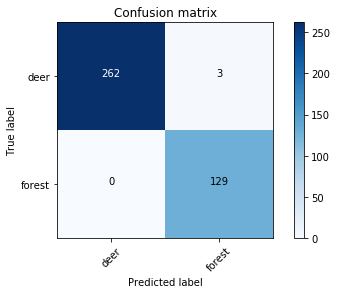

In [13]:
plot_confusion_matrix(cm, data.classes)

In [14]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(probs[x],data.val_ds.fnames[x]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


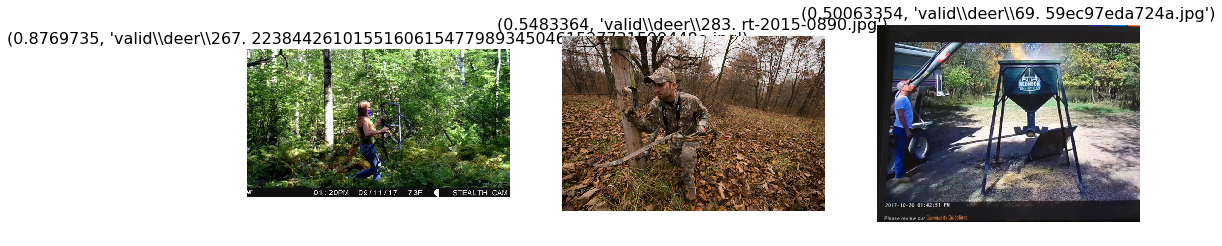

In [15]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


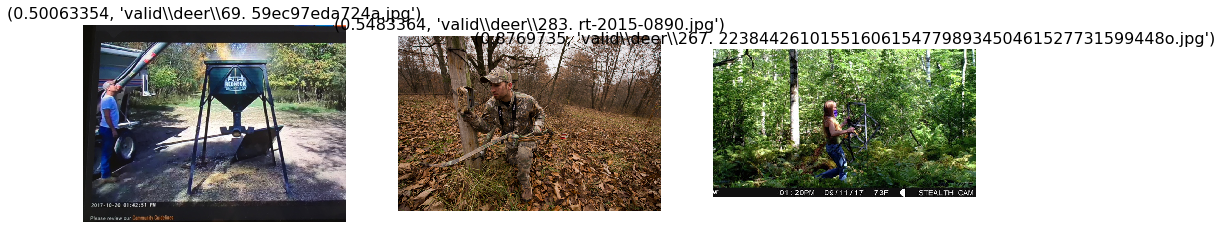

In [16]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Individual prediction from Ponderosa photos

In [17]:
PATH2 = "data/deer/ponderosa/"
PATH2
fn = "1.jpg"

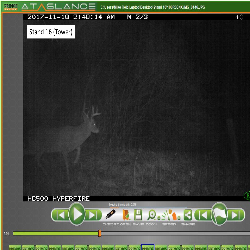

In [18]:
Image.open(PATH2 + fn).resize((250, 250))

### Method 2

In [19]:
fn = "18.jpg"

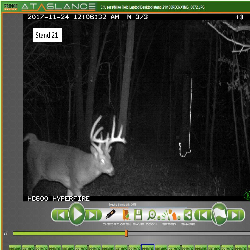

In [20]:
Image.open(PATH2 + fn).resize((250, 250))

In [21]:
num_ponderosa = 21

In [22]:

for i in range(1,num_ponderosa+1):
    fn = str(i) + ".jpg"
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(open_image(PATH2 + fn)) # open_image() returns numpy.ndarray
    print(PATH2 + fn)
    preds = learn.predict_array(im[None])
    print (preds)
    

data/deer/ponderosa/1.jpg
[[-0.20235 -1.69723]]
data/deer/ponderosa/2.jpg
[[-0.00009 -9.34248]]
data/deer/ponderosa/3.jpg
[[-0.00041 -7.79025]]
data/deer/ponderosa/4.jpg
[[-0.0296  -3.53475]]
data/deer/ponderosa/5.jpg
[[-0.03167 -3.46831]]
data/deer/ponderosa/6.jpg
[[-0.00027 -8.23428]]
data/deer/ponderosa/7.jpg
[[-0.0002  -8.49469]]
data/deer/ponderosa/8.jpg
[[-2.84413 -0.05995]]
data/deer/ponderosa/9.jpg
[[-0.00124 -6.69416]]
data/deer/ponderosa/10.jpg
[[-0.00051 -7.58209]]
data/deer/ponderosa/11.jpg
[[-0.0001  -9.16491]]
data/deer/ponderosa/12.jpg
[[-0.07258 -2.65908]]
data/deer/ponderosa/13.jpg
[[-0.00202 -6.20696]]
data/deer/ponderosa/14.jpg
[[ -0.00002 -10.59634]]
data/deer/ponderosa/15.jpg
[[-0.11459 -2.2231 ]]
data/deer/ponderosa/16.jpg
[[-0.06336 -2.79051]]
data/deer/ponderosa/17.jpg
[[-0.01062 -4.55043]]
data/deer/ponderosa/18.jpg
[[-0.00078 -7.15153]]
data/deer/ponderosa/19.jpg
[[-0.00075 -7.19131]]
data/deer/ponderosa/20.jpg
[[-16.58792   0.     ]]
data/deer/ponderosa/21.jp